In [330]:
import numpy as np
import math
from math import sin, cos, tan
from numpy import matmul as mm  # Matrix multiplication
from numpy import linalg as lg
import pandas as pd
from matplotlib import pyplot as plt

print('----- Import Finished -----')


----- Import Finished -----


In [331]:
# def sin(o):
#     return math.sin(o)

# def cos(o):
#     return math.cos(o)

# def tan(o):
#     return math.tan(o)


class laminate():
    def __init__(self):
        #super(self).__init__()
        # Bacis parameters of composite
        self.E1f = 250e9  # Young Modulus of fibers
        self.E2f = 15e9  # Young Modulus of fibers in 2 direction
        self.Rf = 0.5   # Fiber volume fraction
        self.V12f = 0.2 # Poisson's ratio of fibers
        self.G12f = 14e9
        # self.G12f = self.E1f / (2 + 2 * self.V12f) # Shear Modulus of fibers

        self.Em = 8e9      # Young Modulus of matrix
        self.Vm = 0.28   # Poisson's ratio of matrix
        self.Gm = self.Em / (2 + 2 * self.Vm)  # Shear Modulus of matrix

        self.etaE = (self.E2f - self.Em) / (self.E2f + self.Em)
        self.etaG = (self.G12f - self.Gm) / (self.G12f + self.Gm)



        # Local coordinate system
        self.E11 = self.Rf * self.E1f + (1 - self.Rf) * self.Em                     # Young Modulus in 1
        self.E22 = self.Em * (1 + self.etaE * self.Rf) / (1 - self.etaE * self.Rf)  # Young Modulus in 2
        self.V12 = self.Rf * self.V12f + (1 - self.Rf) * self.Vm                    # Poisson's ratio 21
        self.V21 = self.V12
        #self.V21 = (self.V12 * self.E22) / self.E11                              # Poisson's ratio 12, V21/E11 = V12/E22
        self.G12 = self.Gm * (1 + self.etaG * self.Rf) / (1 - self.etaG * self.Rf)  # Shear modulus of composite

        # parameters of composite
        self.N = 2                                     # number of plys
        self.thickness = 22.8e-3                          # Thickness of the composite
        # self.ply_angle = [0, 90]                       # angle of each plys
        self.angle = None                              # radian angle
        self.z = None                                  # ply

        # Matrix
        self.S = None          # positive axis compliance matrix
        self.Q = None          # positive-axis modulus matrix
        self.T_stress = None   # stress conversion matrix
        self.T_strain = None   # strain conversion matrix

    def plys(self, th1, th2):
        N = self.N             # number of plies
        t_ply = [self.thickness / self.N] * N  # ply thickness in m
        t_LAM = 0

        for i in range(N):
            t_LAM += t_ply[i]  # laminate thickness in m, 8 multiply by the thinkness of each ply

        # Distance from laminate mid-plane to out surfaces of plies in m
        z = self.z
        z = [0] * (N+1)
        for i in range(N+1):
            z[i] = (-t_LAM / 2) + (i * t_ply[i-1])
        #print(z[1])

        # Distance from laminate mid-plane to mid-planes of plies in m
        z_mid_plane = [0] * N
        for i in range(N):
            z_mid_plane[i] = (-t_LAM / 2) - (t_ply[i]/2) + ((i+1) * t_ply[i])

        # Enter a desired ply orientation angle in degrees here:
        ply_angle = [th1, th2]
        # Ply orientation angle translated to radians to simplify equations below
        angle = [0] * N
        for i in range(N):
            angle[i] = math.radians(ply_angle[i])

        # Stress Transformation (Global to Local), pg 112
        self.T_stress = [0] * N
        for i in range(N):
            self.T_stress[i] = np.array([[cos(angle[i])**2, sin(angle[i])**2, 2*sin(angle[i])*cos(angle[i])], [sin(angle[i])**2, cos(angle[i])**2,
             -2*sin(angle[i])*cos(angle[i])], [-sin(angle[i])*cos(angle[i]), sin(angle[i])*cos(angle[i]), cos(angle[i])**2-sin(angle[i])**2]])

        # Strain Transformation (Global-to-Local), pg 113
        self.T_strain = [0] * N
        for i in range(N):
            self.T_strain[i] = np.array([[cos(angle[i])**2, sin(angle[i])**2, sin(angle[i])*cos(angle[i])], [sin(angle[i])**2, cos(angle[i])**2,
            -sin(angle[i])*cos(angle[i])], [-2*sin(angle[i])*cos(angle[i]), 2*sin(angle[i])*cos(angle[i]), cos(angle[i])**2-sin(angle[i])**2]])

        self.angle = angle
        self.t_ply = t_ply
        self.z = z

        # for i in range(8):
        #     print(self.T_stress[i])
        return self.T_stress, self.T_strain, self.angle, self.t_ply, self.z




    def cal_ABD(self, th1, th2):


        laminate.plys(self, th1 = th1, th2 = th2)

        # Parameters of the composite
        E11 = self.E11
        E22 = self.E22
        V21 = self.V21
        V12 = self.V12
        G12 = self.G12

        N = self.N
        t_ply = self.t_ply
        T_stress = self.T_stress
        T_strain = self.T_strain
        z = self.z
        #print('z:', z)

        # The local/lamina compliance matrix
        S11 = 1/E11
        S12 = -V21/E22
        S21 = -V12/E11
        S22 = 1/E22
        S66 = 1/G12
        S16 = S61 = S26 = S62 = 0
        S = np.array([[S11, S12, 0], [S21, S22, 0], [0, 0, S66]])

        # The local/lamina stiffness matrix
        Q_loc = lg.inv(S)  # The inverse of the S matrix
        #print('Q_loc:', Q_loc)

        # The global/laminate stiffness and compliance matrices
        Q_glo = [0.0] * N
        for i in range(N):
            Q_glo[i] = mm(lg.inv(T_stress[i]), mm(Q_loc, T_strain[i]))
        #print('Q_glo；', Q_glo)

        # Calculate the ABD Matrix
        A = [[0.0]*3] * 3
        for i in range(N):
            A += Q_glo[i] * t_ply[i]

        B = [[0.0]*3] * 3
        for i in range(N):
            B += (1 / 2) * (Q_glo[i] * ((z[i + 1]**2) - ((z[i + 1] - t_ply[i])**2)))

        D = [[0.0]*3] * 3
        for i in range(N):
            D += (1/3) * (Q_glo[i] * ((z[i+1] ** 3) - ((z[i+1] - t_ply[i]) ** 3)))

        ABD = np.array([[A[0][0],A[0][1],A[0][2],B[0][0],B[0][1],B[0][2]],
                        [A[1][0],A[1][1],A[1][2],B[1][0],B[1][1],B[1][2]],
                        [A[2][0],A[2][1],A[2][2],B[2][0],B[2][1],B[2][2]],
                        [B[0][0],B[0][1],B[0][2],D[0][0],D[0][1],D[0][2]],
                        [B[1][0],B[1][1],B[1][2],D[1][0],D[1][1],D[1][2]],
                        [B[2][0],B[2][1],B[2][2],D[2][0],D[2][1],D[2][2]]])

        ABD_inv = lg.inv(ABD)

        # Round tiny numbers to zero
        for i in range(3):
            for j in range(3):
                if 0.000000001 > A[i][j] > -0.000000001:
                    A[i][j] = 0

        for i in range(3):
            for j in range(3):
                if 0.000000001 > B[i][j] > -0.000000001:
                    B[i][j] = 0

        for i in range(3):
            for j in range(3):
                if 0.000000001 > D[i][j] > -0.000000001:
                    D[i][j] = 0

        for i in range(6):
            for j in range(6):
                if 0.000000001 > ABD_inv[i][j] > -0.000000001:
                    ABD_inv[i][j] = 0

        for i in range(6):
            for j in range(6):
                if 0.000000001 > ABD[i][j] > -0.000000001:
                    ABD[i][j] = 0

        return A, B, D, ABD, ABD_inv


    def Result_print(self, th1, th2):

        A, B, D, ABD, ABD_inv = laminate.cal_ABD(self, th1 = th1, th2 = th2)

        # # Printing the A, B and D matrices
        # print("\n[A] matrix:")
        # print('[' + format(A[0][0], '^12.2e') + format(A[0][1], '^12.2e') + format(A[0][2], '^12.2e') + ']')
        # print('[' + format(A[1][0], '^12.2e') + format(A[1][1], '^12.2e') + format(A[1][2], '^12.2e') + ']')
        # print('[' + format(A[2][0], '^12.2e') + format(A[2][1], '^12.2e') + format(A[2][2], '^12.2e') + ']')
        # print("\n[B] matrix:")
        # print('[' + format(B[0][0], '^12.2e') + format(B[0][1], '^12.2e') + format(B[0][2], '^12.2e') + ']')
        # print('[' + format(B[1][0], '^12.2e') + format(B[1][1], '^12.2e') + format(B[1][2], '^12.2e') + ']')
        # print('[' + format(B[2][0], '^12.2e') + format(B[2][1], '^12.2e') + format(B[2][2], '^12.2e') + ']')
        # print("\n[D] matrix:")
        # print('[' + format(D[0][0], '^12.2e') + format(D[0][1], '^12.2e') + format(D[0][2], '^12.2e') + ']')
        # print('[' + format(D[1][0], '^12.2e') + format(D[1][1], '^12.2e') + format(D[1][2], '^12.2e') + ']')
        # print('[' + format(D[2][0], '^12.2e') + format(D[2][1], '^12.2e') + format(D[2][2], '^12.2e') + ']')

        # Printing the [ABD] matrix
        print("\n[ABD] matrix:")
        print('[' + format(ABD[0][0], '^12.2e') + format(ABD[0][1], '^12.2e') + format(ABD[0][2], '^12.2e') + format(ABD[0][3], '^12.2e') + format(ABD[0][4], '^12.2e') + format(ABD[0][5], '^12.2e') + ']')
        print('[' + format(ABD[1][0], '^12.2e') + format(ABD[1][1], '^12.2e') + format(ABD[1][2], '^12.2e') + format(ABD[1][3], '^12.2e') + format(ABD[1][4], '^12.2e') + format(ABD[1][5], '^12.2e') + ']')
        print('[' + format(ABD[2][0], '^12.2e') + format(ABD[2][1], '^12.2e') + format(ABD[2][2], '^12.2e') + format(ABD[2][3], '^12.2e') + format(ABD[2][4], '^12.2e') + format(ABD[2][5], '^12.2e') + ']')
        print('[' + format(ABD[3][0], '^12.2e') + format(ABD[3][1], '^12.2e') + format(ABD[3][2], '^12.2e') + format(ABD[3][3], '^12.2e') + format(ABD[3][4], '^12.2e') + format(ABD[3][5], '^12.2e') + ']')
        print('[' + format(ABD[4][0], '^12.2e') + format(ABD[4][1], '^12.2e') + format(ABD[4][2], '^12.2e') + format(ABD[4][3], '^12.2e') + format(ABD[4][4], '^12.2e') + format(ABD[4][5], '^12.2e') + ']')
        print('[' + format(ABD[5][0], '^12.2e') + format(ABD[5][1], '^12.2e') + format(ABD[5][2], '^12.2e') + format(ABD[5][3], '^12.2e') + format(ABD[5][4], '^12.2e') + format(ABD[5][5], '^12.2e') + ']')


        # Printing the inverse [ABD] matrix
        print("\n[ABD]\N{SUPERSCRIPT MINUS}\N{SUPERSCRIPT ONE} matrix")
        print('[' + format(ABD_inv[0][0], '^12.2e') + format(ABD_inv[0][1], '^12.2e') + format(ABD_inv[0][2], '^12.2e') + format(ABD_inv[0][3], '^12.2e') + format(ABD_inv[0][4], '^12.2e') + format(ABD_inv[0][5], '^12.2e') + ']')
        print('[' + format(ABD_inv[1][0], '^12.2e') + format(ABD_inv[1][1], '^12.2e') + format(ABD_inv[1][2], '^12.2e') + format(ABD_inv[1][3], '^12.2e') + format(ABD_inv[1][4], '^12.2e') + format(ABD_inv[1][5], '^12.2e') + ']')
        print('[' + format(ABD_inv[2][0], '^12.2e') + format(ABD_inv[2][1], '^12.2e') + format(ABD_inv[2][2], '^12.2e') + format(ABD_inv[2][3], '^12.2e') + format(ABD_inv[2][4], '^12.2e') + format(ABD_inv[2][5], '^12.2e') + ']')
        print('[' + format(ABD_inv[3][0], '^12.2e') + format(ABD_inv[3][1], '^12.2e') + format(ABD_inv[3][2], '^12.2e') + format(ABD_inv[3][3], '^12.2e') + format(ABD_inv[3][4], '^12.2e') + format(ABD_inv[3][5], '^12.2e') + ']')
        print('[' + format(ABD_inv[4][0], '^12.2e') + format(ABD_inv[4][1], '^12.2e') + format(ABD_inv[4][2], '^12.2e') + format(ABD_inv[4][3], '^12.2e') + format(ABD_inv[4][4], '^12.2e') + format(ABD_inv[4][5], '^12.2e') + ']')
        print('[' + format(ABD_inv[5][0], '^12.2e') + format(ABD_inv[5][1], '^12.2e') + format(ABD_inv[5][2], '^12.2e') + format(ABD_inv[5][3], '^12.2e') + format(ABD_inv[5][4], '^12.2e') + format(ABD_inv[5][5], '^12.2e') + ']')



In [332]:
class laminate_Gpa():
    def __init__(self):
        #super(self).__init__()
        # Bacis parameters of composite
        self.E1f = 250  # Young Modulus of fibers
        self.E2f = 15  # Young Modulus of fibers in 2 direction
        self.Rf = 0.5   # Fiber volume fraction
        self.V12f = 0.2 # Poisson's ratio of fibers
        self.G12f = 14 # Shear Modulus of fibers

        self.Em = 12      # Young Modulus of matrix
        self.Vm = 0.28   # Poisson's ratio of matrix
        self.Gm = self.Em / (2 + 2 * self.Vm)  # Shear Modulus of matrix

        self.etaE = (self.E2f - self.Em) / (self.E2f + self.Em)
        self.etaG = (self.G12f - self.Gm) / (self.G12f + self.Gm)



        # Local coordinate system
        self.E11 = self.Rf * self.E1f + (1 - self.Rf) * self.Em                     # Young Modulus in 1
        self.E22 = self.Em * (1 + self.etaE * self.Rf) / (1 - self.etaE * self.Rf)  # Young Modulus in 2
        self.V12 = self.Rf * self.V12f + (1 - self.Rf) * self.Vm                    # Poisson's ratio 21
        self.V21 = (self.V12 * self.E22) / self.E11                                # Poisson's ratio 12, V21/E11 = V12/E22
        self.G12 = self.Gm * (1 + self.etaG * self.Rf) / (1 - self.etaG * self.Rf)  # Shear modulus of composite

        # parameters of composite
        self.N = 2                                     # number of plys
        self.thickness = 22.8e-3                          # Thickness of the composite
        # self.ply_angle = [0, 90]                       # angle of each plys
        self.angle = None                              # radian angle
        self.z = None                                  # ply

        # Matrix
        self.S = None          # positive axis compliance matrix
        self.Q = None          # positive-axis modulus matrix
        self.T_stress = None   # stress conversion matrix
        self.T_strain = None   # strain conversion matrix

    def plys(self, th1, th2):
        N = self.N             # number of plies
        t_ply = [self.thickness / self.N] * N  # ply thickness in m
        t_LAM = 0

        for i in range(N):
            t_LAM += t_ply[i]  # laminate thickness in m, 8 multiply by the thinkness of each ply

        # Distance from laminate mid-plane to out surfaces of plies in m
        z = self.z
        z = [0] * (N+1)
        for i in range(N+1):
            z[i] = (-t_LAM / 2) + (i * t_ply[i-1])
        #print(z[1])

        # Distance from laminate mid-plane to mid-planes of plies in m
        z_mid_plane = [0] * N
        for i in range(N):
            z_mid_plane[i] = (-t_LAM / 2) - (t_ply[i]/2) + ((i+1) * t_ply[i])

        # Enter a desired ply orientation angle in degrees here:
        ply_angle = [th1, th2]
        # Ply orientation angle translated to radians to simplify equations below
        angle = [0] * N
        for i in range(N):
            angle[i] = math.radians(ply_angle[i])

        # Stress Transformation (Global to Local), pg 112
        self.T_stress = [0] * N
        for i in range(N):
            self.T_stress[i] = np.array([[cos(angle[i])**2, sin(angle[i])**2, 2*sin(angle[i])*cos(angle[i])], [sin(angle[i])**2, cos(angle[i])**2,
             -2*sin(angle[i])*cos(angle[i])], [-sin(angle[i])*cos(angle[i]), sin(angle[i])*cos(angle[i]), cos(angle[i])**2-sin(angle[i])**2]])

        # Strain Transformation (Global-to-Local), pg 113
        self.T_strain = [0] * N
        for i in range(N):
            self.T_strain[i] = np.array([[cos(angle[i])**2, sin(angle[i])**2, sin(angle[i])*cos(angle[i])], [sin(angle[i])**2, cos(angle[i])**2,
            -sin(angle[i])*cos(angle[i])], [-2*sin(angle[i])*cos(angle[i]), 2*sin(angle[i])*cos(angle[i]), cos(angle[i])**2-sin(angle[i])**2]])

        self.angle = angle
        self.t_ply = t_ply
        self.z = z

        # for i in range(8):
        #     print(self.T_stress[i])
        return self.T_stress, self.T_strain, self.angle, self.t_ply, self.z




    def cal_ABD(self, th1, th2):


        laminate.plys(self, th1 = th1, th2 = th2)

        # Parameters of the composite
        E11 = self.E11
        E22 = self.E22
        V21 = self.V21
        V12 = self.V12
        G12 = self.G12

        N = self.N
        t_ply = self.t_ply
        T_stress = self.T_stress
        T_strain = self.T_strain
        z = self.z
        #print('z:', z)

        # The local/lamina compliance matrix
        S11 = 1/E11
        S12 = -V21/E22
        S21 = -V12/E11
        S22 = 1/E22
        S66 = 1/G12
        S16 = S61 = S26 = S62 = 0
        S = np.array([[S11, S12, 0], [S21, S22, 0], [0, 0, S66]])

        # The local/lamina stiffness matrix
        Q_loc = lg.inv(S)  # The inverse of the S matrix
        #print('Q_loc:', Q_loc)

        # The global/laminate stiffness and compliance matrices
        Q_glo = [0.0] * N
        for i in range(N):
            Q_glo[i] = mm(lg.inv(T_stress[i]), mm(Q_loc, T_strain[i]))
        #print('Q_glo；', Q_glo)

        # Calculate the ABD Matrix
        A = [[0.0]*3] * 3
        for i in range(N):
            A += Q_glo[i] * t_ply[i]

        B = [[0.0]*3] * 3
        for i in range(N):
            B += (1 / 2) * (Q_glo[i] * ((z[i + 1]**2) - ((z[i + 1] - t_ply[i])**2)))

        D = [[0.0]*3] * 3
        for i in range(N):
            D += (1/3) * (Q_glo[i] * ((z[i+1] ** 3) - ((z[i+1] - t_ply[i]) ** 3)))

        ABD = np.array([[A[0][0],A[0][1],A[0][2],B[0][0],B[0][1],B[0][2]],
                        [A[1][0],A[1][1],A[1][2],B[1][0],B[1][1],B[1][2]],
                        [A[2][0],A[2][1],A[2][2],B[2][0],B[2][1],B[2][2]],
                        [B[0][0],B[0][1],B[0][2],D[0][0],D[0][1],D[0][2]],
                        [B[1][0],B[1][1],B[1][2],D[1][0],D[1][1],D[1][2]],
                        [B[2][0],B[2][1],B[2][2],D[2][0],D[2][1],D[2][2]]])

        ABD_inv = lg.inv(ABD)

        # Round tiny numbers to zero
        for i in range(3):
            for j in range(3):
                if 0.000000001 > A[i][j] > -0.000000001:
                    A[i][j] = 0

        for i in range(3):
            for j in range(3):
                if 0.000000001 > B[i][j] > -0.000000001:
                    B[i][j] = 0

        for i in range(3):
            for j in range(3):
                if 0.000000001 > D[i][j] > -0.000000001:
                    D[i][j] = 0

        for i in range(6):
            for j in range(6):
                if 0.000000001 > ABD_inv[i][j] > -0.000000001:
                    ABD_inv[i][j] = 0

        for i in range(6):
            for j in range(6):
                if 0.000000001 > ABD[i][j] > -0.000000001:
                    ABD[i][j] = 0

        return A, B, D, ABD, ABD_inv
    
    
    def Result_print(self, th1, th2):
    
        A, B, D, ABD, ABD_inv = laminate.cal_ABD(self, th1 = th1, th2 = th2)

        # # Printing the A, B and D matrices
        # print("\n[A] matrix:")
        # print('[' + format(A[0][0], '^12.2e') + format(A[0][1], '^12.2e') + format(A[0][2], '^12.2e') + ']')
        # print('[' + format(A[1][0], '^12.2e') + format(A[1][1], '^12.2e') + format(A[1][2], '^12.2e') + ']')
        # print('[' + format(A[2][0], '^12.2e') + format(A[2][1], '^12.2e') + format(A[2][2], '^12.2e') + ']')
        # print("\n[B] matrix:")
        # print('[' + format(B[0][0], '^12.2e') + format(B[0][1], '^12.2e') + format(B[0][2], '^12.2e') + ']')
        # print('[' + format(B[1][0], '^12.2e') + format(B[1][1], '^12.2e') + format(B[1][2], '^12.2e') + ']')
        # print('[' + format(B[2][0], '^12.2e') + format(B[2][1], '^12.2e') + format(B[2][2], '^12.2e') + ']')
        # print("\n[D] matrix:")
        # print('[' + format(D[0][0], '^12.2e') + format(D[0][1], '^12.2e') + format(D[0][2], '^12.2e') + ']')
        # print('[' + format(D[1][0], '^12.2e') + format(D[1][1], '^12.2e') + format(D[1][2], '^12.2e') + ']')
        # print('[' + format(D[2][0], '^12.2e') + format(D[2][1], '^12.2e') + format(D[2][2], '^12.2e') + ']')

        # Printing the [ABD] matrix
        print("\n[ABD] matrix:")
        print('[' + format(ABD[0][0], '^12.2e') + format(ABD[0][1], '^12.2e') + format(ABD[0][2], '^12.2e') + format(ABD[0][3], '^12.2e') + format(ABD[0][4], '^12.2e') + format(ABD[0][5], '^12.2e') + ']')
        print('[' + format(ABD[1][0], '^12.2e') + format(ABD[1][1], '^12.2e') + format(ABD[1][2], '^12.2e') + format(ABD[1][3], '^12.2e') + format(ABD[1][4], '^12.2e') + format(ABD[1][5], '^12.2e') + ']')
        print('[' + format(ABD[2][0], '^12.2e') + format(ABD[2][1], '^12.2e') + format(ABD[2][2], '^12.2e') + format(ABD[2][3], '^12.2e') + format(ABD[2][4], '^12.2e') + format(ABD[2][5], '^12.2e') + ']')
        print('[' + format(ABD[3][0], '^12.2e') + format(ABD[3][1], '^12.2e') + format(ABD[3][2], '^12.2e') + format(ABD[3][3], '^12.2e') + format(ABD[3][4], '^12.2e') + format(ABD[3][5], '^12.2e') + ']')
        print('[' + format(ABD[4][0], '^12.2e') + format(ABD[4][1], '^12.2e') + format(ABD[4][2], '^12.2e') + format(ABD[4][3], '^12.2e') + format(ABD[4][4], '^12.2e') + format(ABD[4][5], '^12.2e') + ']')
        print('[' + format(ABD[5][0], '^12.2e') + format(ABD[5][1], '^12.2e') + format(ABD[5][2], '^12.2e') + format(ABD[5][3], '^12.2e') + format(ABD[5][4], '^12.2e') + format(ABD[5][5], '^12.2e') + ']')


        # Printing the inverse [ABD] matrix
        print("\n[ABD]\N{SUPERSCRIPT MINUS}\N{SUPERSCRIPT ONE} matrix")
        print('[' + format(ABD_inv[0][0], '^12.2e') + format(ABD_inv[0][1], '^12.2e') + format(ABD_inv[0][2], '^12.2e') + format(ABD_inv[0][3], '^12.2e') + format(ABD_inv[0][4], '^12.2e') + format(ABD_inv[0][5], '^12.2e') + ']')
        print('[' + format(ABD_inv[1][0], '^12.2e') + format(ABD_inv[1][1], '^12.2e') + format(ABD_inv[1][2], '^12.2e') + format(ABD_inv[1][3], '^12.2e') + format(ABD_inv[1][4], '^12.2e') + format(ABD_inv[1][5], '^12.2e') + ']')
        print('[' + format(ABD_inv[2][0], '^12.2e') + format(ABD_inv[2][1], '^12.2e') + format(ABD_inv[2][2], '^12.2e') + format(ABD_inv[2][3], '^12.2e') + format(ABD_inv[2][4], '^12.2e') + format(ABD_inv[2][5], '^12.2e') + ']')
        print('[' + format(ABD_inv[3][0], '^12.2e') + format(ABD_inv[3][1], '^12.2e') + format(ABD_inv[3][2], '^12.2e') + format(ABD_inv[3][3], '^12.2e') + format(ABD_inv[3][4], '^12.2e') + format(ABD_inv[3][5], '^12.2e') + ']')
        print('[' + format(ABD_inv[4][0], '^12.2e') + format(ABD_inv[4][1], '^12.2e') + format(ABD_inv[4][2], '^12.2e') + format(ABD_inv[4][3], '^12.2e') + format(ABD_inv[4][4], '^12.2e') + format(ABD_inv[4][5], '^12.2e') + ']')
        print('[' + format(ABD_inv[5][0], '^12.2e') + format(ABD_inv[5][1], '^12.2e') + format(ABD_inv[5][2], '^12.2e') + format(ABD_inv[5][3], '^12.2e') + format(ABD_inv[5][4], '^12.2e') + format(ABD_inv[5][5], '^12.2e') + ']')


# Question 3-a
Show the inverse of the ABD matrix for the case [0, 90]. Which couplings are present? What is the reason for these couplings?   


In [333]:
laminate_Gpa().Result_print(th1=0, th2=90)


[ABD] matrix:
[  1.66e+00    7.38e-02    0.00e+00   -7.69e-03    0.00e+00    0.00e+00  ]
[  7.38e-02    1.66e+00    0.00e+00    0.00e+00    7.69e-03    0.00e+00  ]
[  0.00e+00    0.00e+00    1.78e-01    0.00e+00    0.00e+00    0.00e+00  ]
[ -7.69e-03    0.00e+00    0.00e+00    7.17e-05    3.20e-06    0.00e+00  ]
[  0.00e+00    7.69e-03    0.00e+00    3.20e-06    7.17e-05    0.00e+00  ]
[  0.00e+00    0.00e+00    0.00e+00    0.00e+00    0.00e+00    7.70e-06  ]

[ABD]⁻¹ matrix
[  1.21e+00   -5.38e-02    0.00e+00    1.29e+02    0.00e+00    0.00e+00  ]
[ -5.38e-02    1.21e+00    0.00e+00    0.00e+00   -1.29e+02    0.00e+00  ]
[  0.00e+00    0.00e+00    5.62e+00    0.00e+00    0.00e+00    0.00e+00  ]
[  1.29e+02    0.00e+00    0.00e+00    2.78e+04   -1.24e+03    0.00e+00  ]
[  0.00e+00   -1.29e+02    0.00e+00   -1.24e+03    2.78e+04    0.00e+00  ]
[  0.00e+00    0.00e+00    0.00e+00    0.00e+00    0.00e+00    1.30e+05  ]


In [334]:
laminate().Result_print(th1=0, th2=90)


[ABD] matrix:
[  1.69e+09    4.06e+08    2.30e-09   -8.15e+06   -1.95e+06    0.00e+00  ]
[  4.06e+08    1.69e+09    6.42e-08    1.95e+06    8.15e+06    0.00e+00  ]
[  2.33e-08    8.52e-08    1.38e+08    0.00e+00    0.00e+00    0.00e+00  ]
[ -8.15e+06   -1.95e+06    0.00e+00    7.33e+04    1.76e+04    0.00e+00  ]
[  1.95e+06    8.15e+06    0.00e+00    1.76e+04    7.33e+04    0.00e+00  ]
[  0.00e+00    0.00e+00    0.00e+00    0.00e+00    0.00e+00    5.96e+03  ]

[ABD]⁻¹ matrix
[  1.35e-09    0.00e+00    0.00e+00    1.50e-07    3.60e-08    0.00e+00  ]
[  0.00e+00    1.35e-09    0.00e+00   -3.60e-08   -1.50e-07    0.00e+00  ]
[  0.00e+00    0.00e+00    7.27e-09    0.00e+00    0.00e+00    0.00e+00  ]
[  1.50e-07    3.60e-08    0.00e+00    3.11e-05   -7.47e-06    0.00e+00  ]
[ -3.60e-08   -1.50e-07    0.00e+00   -7.47e-06    3.11e-05    0.00e+00  ]
[  0.00e+00    0.00e+00    0.00e+00    0.00e+00    0.00e+00    1.68e-04  ]


# Question 3-b
Show how different components of the inverse of the ABD matrix change in function of both fiber angles (21 figures). 

In [335]:
import seaborn as sns
from matplotlib.pyplot import MultipleLocator


def draw_invABD(m, n):
    data = []
    XI = np.linspace(-90, 90, 181)
    YI = np.linspace(-90, 90, 181)
    f, ax = plt.subplots(figsize=(8, 6))
    for th1 in range(-90, 91):
        for th2 in range(-90, 91):
            A, B, D, ABD, ABD_inv = laminate_Gpa().cal_ABD(th1=th1, th2=th2)
            data.append(ABD_inv[m][n])

    data = np.array(data).reshape(181, 181)
    df = pd.DataFrame(data, index=YI, columns=XI)
    sns.heatmap(df, annot=False, cmap='RdBu_r')
    plt.xlim((-0,180))  
    plt.ylim((-0,180)) 
    major_locator=MultipleLocator(20)
    ax.xaxis.set_major_locator(major_locator)
    ax.yaxis.set_major_locator(major_locator)
    # theta = list(range(-90, 90, 10))
    # # theta = np.linspace(0, 180, 9)
    # plt.xticks(theta)
    # plt.yticks(theta)
    plt.title('I$_{}$$_{}$ of inverse ABD with θ'.format(m+1, n+1))
    plt.xlabel('θ1 (-90 ~ 90 degree)')
    plt.ylabel('θ2 (-90 ~ 90 degree)')
    plt.show()
    data = data.tolist()
    data.clear()
# draw_invABD(0, 0)


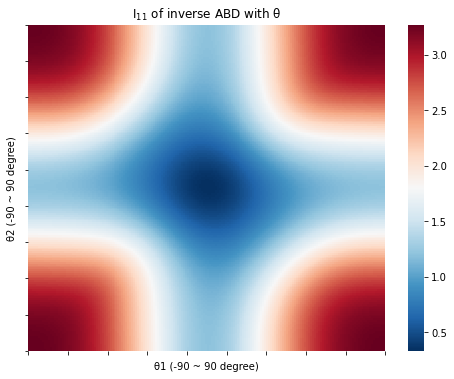

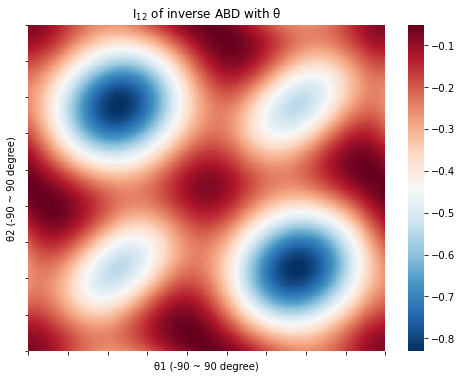

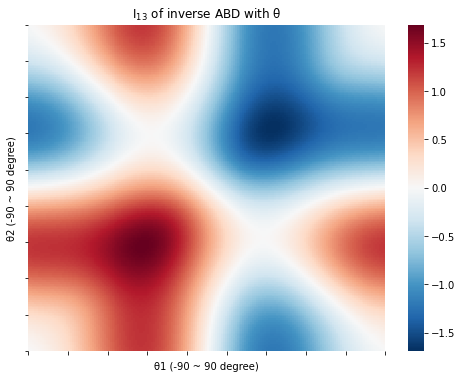

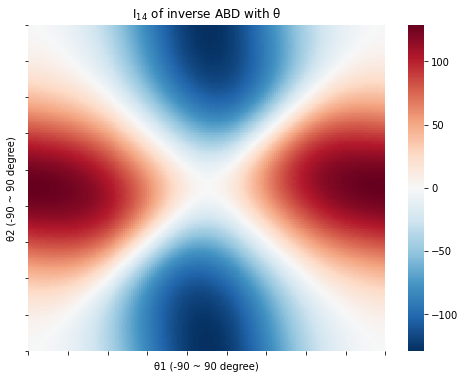

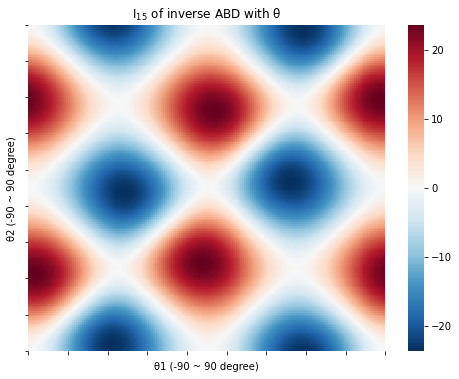

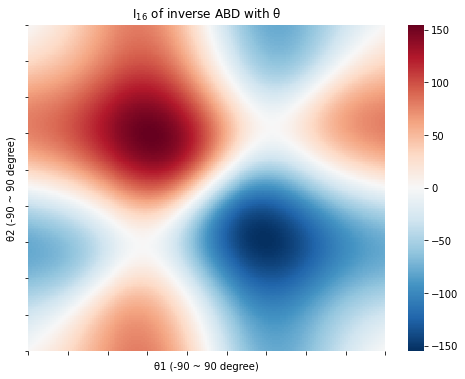

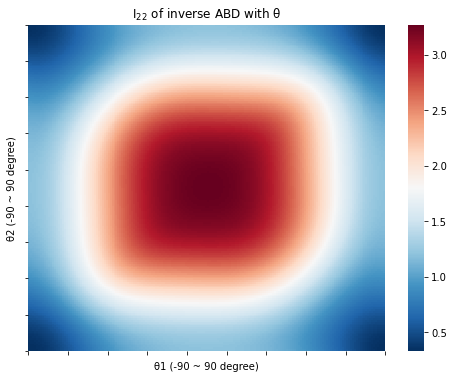

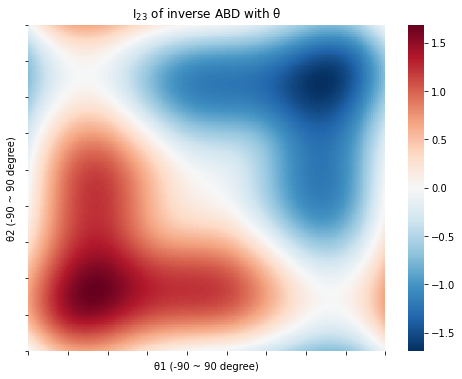

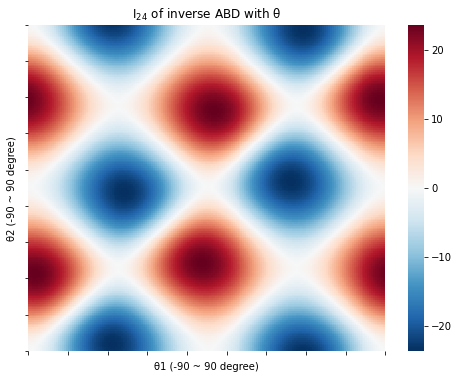

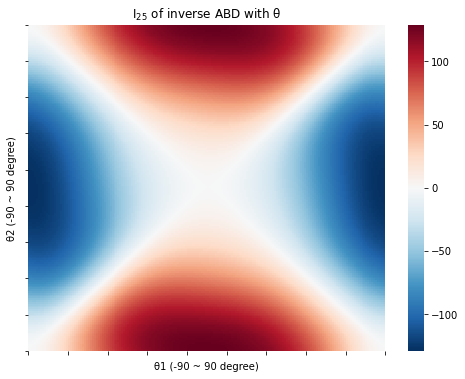

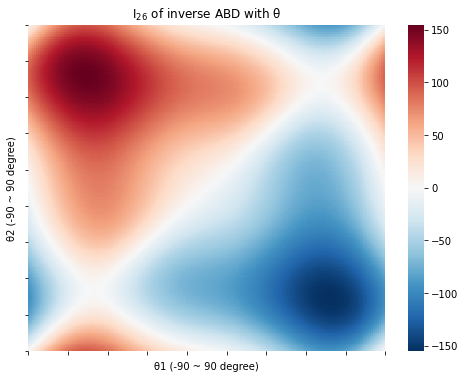

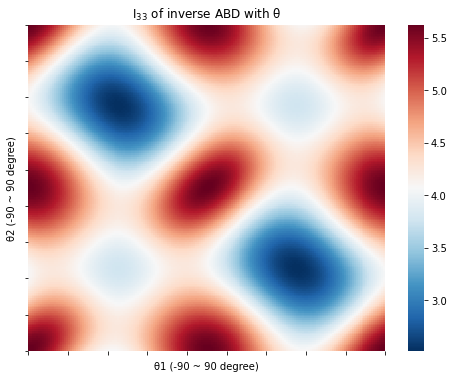

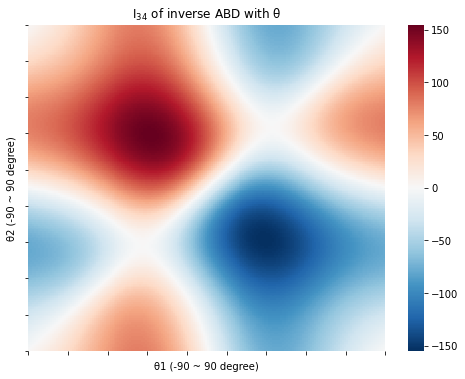

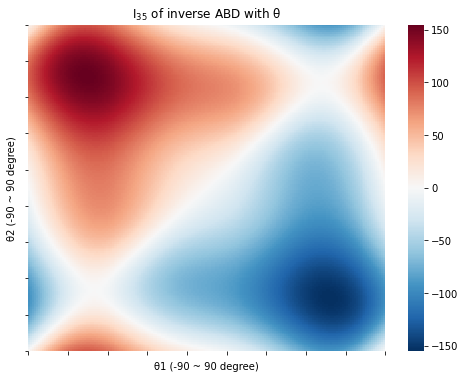

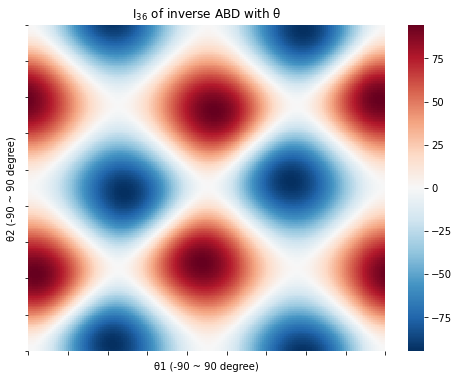

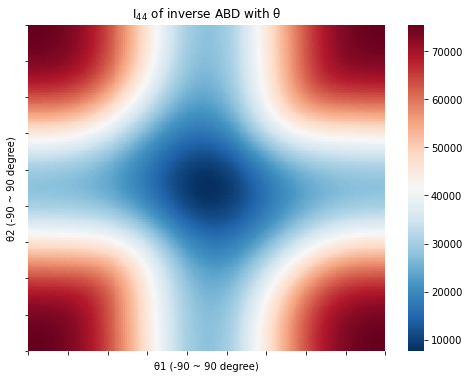

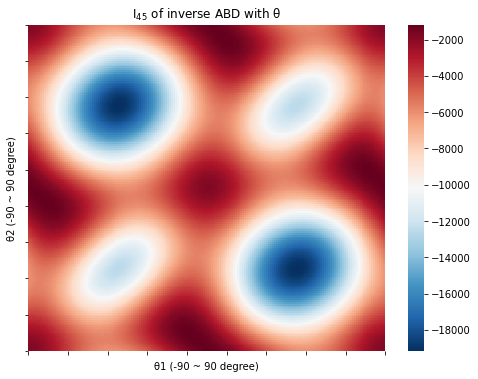

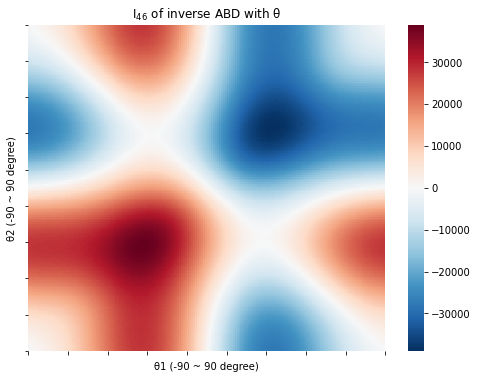

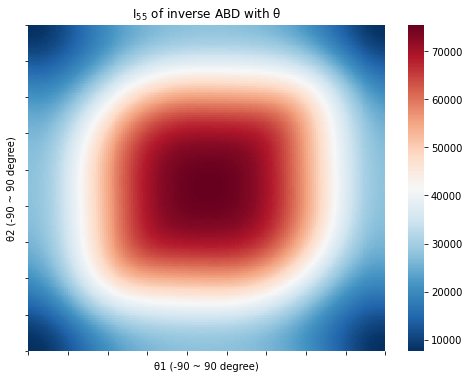

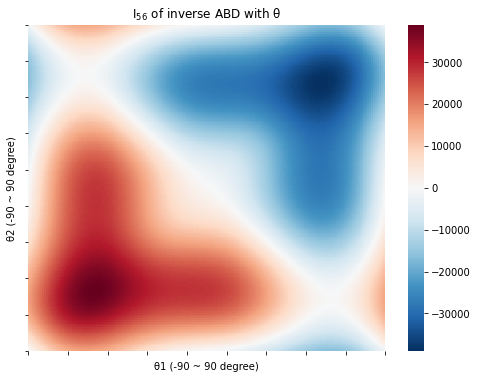

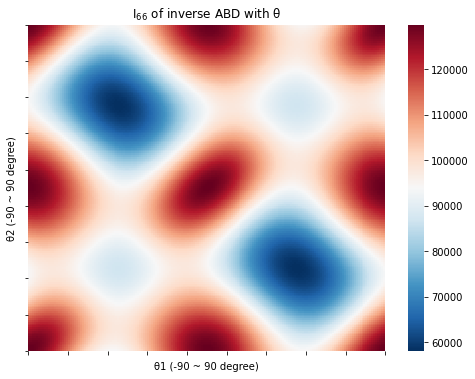

In [336]:
for i in range(6):
    for s in range(i, 6):
        draw_invABD(i, s)

# Question 3-c
 Load the plate by 𝑀xx = 10 𝑘𝑁m/m and show how all six plate deformations change in function of both fiber angles (6 figures).


In [337]:
Load_known_c = [0, 0, 0, 10000, 0, 0]


def draw_deformations(load, plate, label):
    data = []
    f, ax = plt.subplots(figsize=(8, 6))
    XI = np.linspace(-90, 90, 181)
    YI = np.linspace(-90, 90, 181)
    for th1 in range(-90, 91):
        for th2 in range(-90, 91):
            A, B, D, ABD, ABD_inv = laminate().cal_ABD(th1=th1, th2=th2)
            #print(mm(ABD_inv, load))
            #ABD_inv = ABD_inv.tolist().clear()
            data.append(mm(ABD_inv, load))
    data = np.array(data)
    #print(len(data[:, plate]))
    df = pd.DataFrame(data[:, plate].reshape(181, 181), index=YI, columns=XI)
    sns.heatmap(df, annot=False, cmap='RdBu_r')
    plt.xlim((-0,180))
    plt.ylim((-0,180))
    major_locator=MultipleLocator(20)
    plt.title('Variation of {} with θ'.format(label))
    ax.xaxis.set_major_locator(major_locator)
    ax.yaxis.set_major_locator(major_locator)
    plt.xlabel('θ1 (-90 ~ 90 degree)')
    plt.ylabel('θ2 (-90 ~ 90 degree)')

    if plate == 3 : #Kxx

        QQQ = np.array(data[:, 3]).reshape(181, 181) # Kxxmax
        if abs(min(data[:, 3])) < abs(max(data[:, 3])):
            print('kxxmax1 =', max(data[:, 3]))
            angle_max = np.where(QQQ == np.max(QQQ))
            print('The angle of kxxmax:')
            for i in range(len(angle_max)):
                print(angle_max[i]-90)

        else:
            print('kxxmax2 =', -min(data[:, 3]))
            angle_max = np.where(QQQ == np.min(QQQ))
            print('The angle of kxxmax:')
            for i in range(len(angle_max)):
                print(angle_max[i]-90)




        if min(data[:, 3]) >= 0:  # Kxxmin
            print('kxxmin1 =', min(data[:, 3]))
            angle_min = np.where(QQQ == np.min(QQQ))
            print('The angle of kxxmin:')
            for i in range(len(angle_min)):
                if len(angle_min[i]) <= 45:
                    print(angle_min[i]-90)
                else:
                    print('[-90 ~ 90]')
        else:
            print('kxxmin2 =', abs(min(map(abs, data[:, 3]))))
            angle_min = np.where(QQQ == -min(map(abs, data[:, 3])))
            print('The angle of kxxmin:')
            for i in range(len(angle_min)):
                if len(angle_min[i]) <= 45:
                    print(angle_min[i]-90)
                else:
                    print('[-90 ~ 90]')

    if plate == 3 : # Kxy

        SSS = np.array(data[:, 5]).reshape(181, 181)  # Kxymax
        if abs(min(data[:, 5])) < abs(max(data[:, 5])):
            print('kxymax1 =', max(data[:, 5]))
            angle2_max = np.where(SSS == np.max(SSS))
            print('The angle of kxymax:')
            for i in range(len(angle2_max)):
                print(angle2_max[i]-90)
        else:
            print('kxymax2 =', -min(data[:, 5]))
            angle2_max = np.where(SSS == np.min(SSS))
            print('The angle of kxymax:')
            for i in range(len(angle2_max)):
                print(angle2_max[i]-90)


        if min(data[:, 5]) > 0:  # Kxymin
            print('kxymin1 =', min(data[:, 5]))
            angle2_min = np.where(SSS == np.min(SSS))
            print('The angle of kxymin:')
            for i in range(len(angle2_min)):
                if len(angle2_min[i]) <= 45:
                    print(angle2_min[i]-90)
                else:
                    print('[-90 ~ 90]')
        else:
            print('kxymin2 =', abs(min(map(abs, data[:, 5]))))
            angle2_min = np.where(SSS == min(map(abs, data[:, 5])))
            print('The angle of kxymin:')
            for i in range(len(angle2_min)):
                if len(angle2_min[i]) <= 45:
                    print(angle2_min[i]-90)
                else:
                    print('[-90 ~ 90]')


# draw_deformations(load=Load_known_c, plate=5, label='kap$_x$$_y$')
# draw_deformations(load=Load_known_c, plate=3, label='ep$_x$$_x$')

kxxmax1 = 0.9312696626843858
The angle of kxxmax:
[-90 -90  90  90]
[-90  90 -90  90]
kxxmin1 = 0.07848506002349026
The angle of kxxmin:
[0]
[0]
kxymax2 = 0.5654730361082272
The angle of kxymax:
[36]
[36]
kxymin2 = 0.0
The angle of kxymin:
[-90 ~ 90]
[-90 ~ 90]


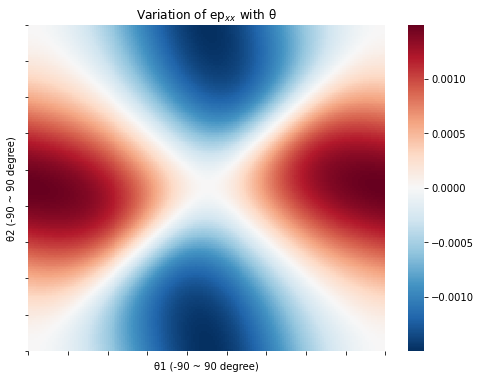

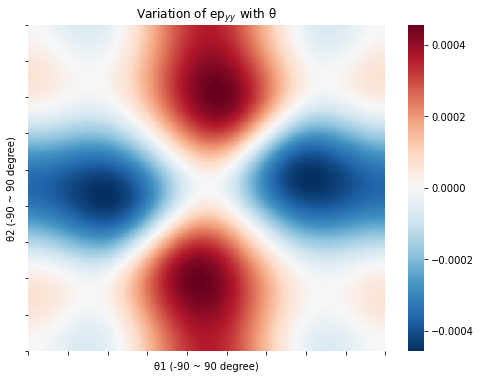

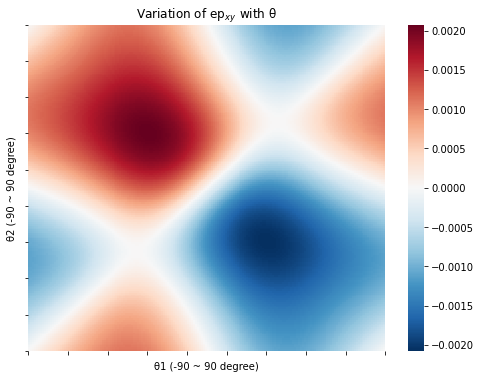

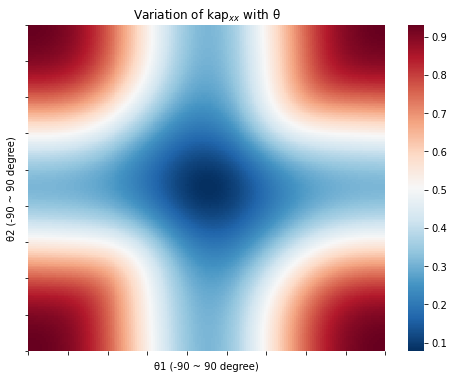

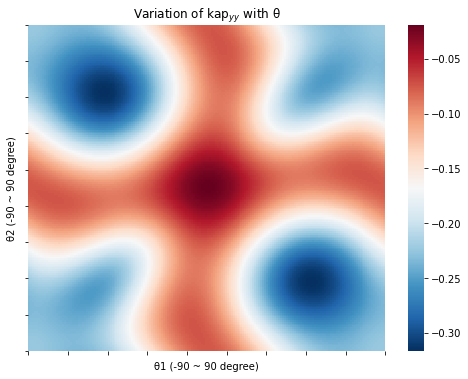

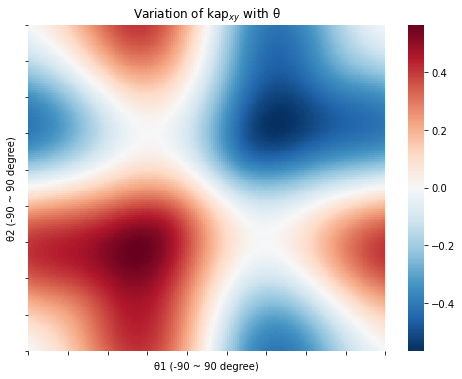

In [338]:
draw_deformations(load=Load_known_c, plate=0, label='ep$_x$$_x$')
draw_deformations(load=Load_known_c, plate=1, label='ep$_y$$_y$')
draw_deformations(load=Load_known_c, plate=2, label='ep$_x$$_y$')
draw_deformations(load=Load_known_c, plate=3, label='kap$_x$$_x$')
draw_deformations(load=Load_known_c, plate=4, label='kap$_y$$_y$')
draw_deformations(load=Load_known_c, plate=5, label='kap$_x$$_y$')

# Question 3-d
Load the plate by 𝑀xy = 10 𝑘𝑁m/m and show how all six plate deformations change in function of both fiber angles (6 figures).

In [339]:
Load_known_d = [0, 0, 0, 0, 0, 10000]

# draw_deformations(load=Load_known_d, plate=5, label='kap$_x$$_y$')
# draw_deformations(load=Load_known_d, plate=3, label='ep$_x$$_x$')

kxxmax2 = 0.37521859376394845
The angle of kxxmax:
[33]
[33]
kxxmin2 = 0.0
The angle of kxxmin:
[-90 ~ 90]
[-90 ~ 90]
kxymax1 = 1.678267127265734
The angle of kxymax:
[-90 -90 -90   0   0   0  90  90  90]
[-90   0  90 -90   0  90 -90   0  90]
kxymin1 = 0.7720098075011705
The angle of kxymin:
[-45  45]
[ 45 -45]


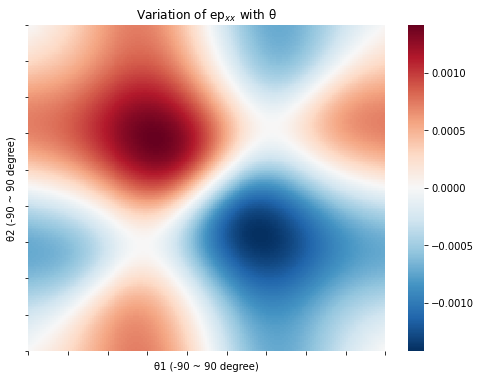

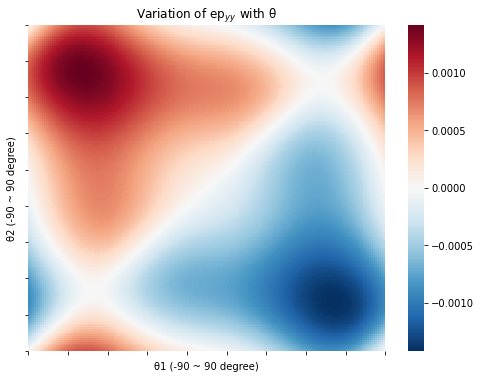

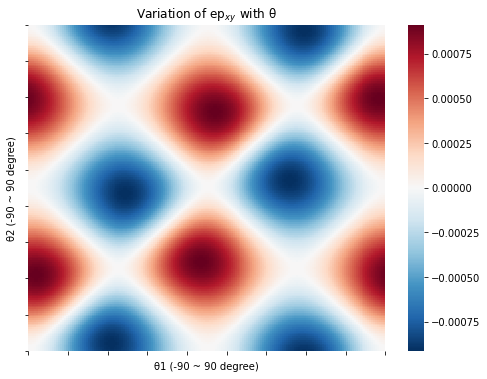

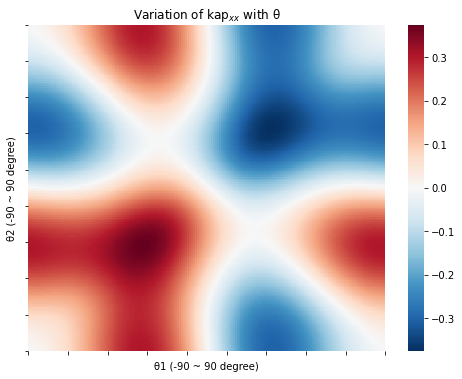

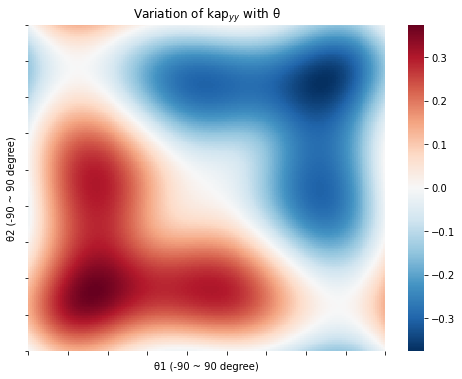

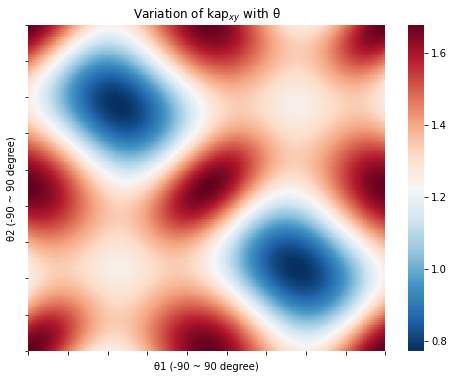

In [340]:
draw_deformations(load=Load_known_d, plate=0, label='ep$_x$$_x$')
draw_deformations(load=Load_known_d, plate=1, label='ep$_y$$_y$')
draw_deformations(load=Load_known_d, plate=2, label='ep$_x$$_y$')
draw_deformations(load=Load_known_d, plate=3, label='kap$_x$$_x$')
draw_deformations(load=Load_known_d, plate=4, label='kap$_y$$_y$')
draw_deformations(load=Load_known_d, plate=5, label='kap$_x$$_y$')

# Question 3-e
Load the plate by 𝑀xx = 𝑀xy = 10 𝑘𝑁m/m and show how all six plate deformations change in function of both fiber angles (6 figures).

In [341]:
Load_known_e = [0, 0, 0, 10000, 0, 10000]

# draw_deformations(load=Load_known_e, plate=3, label='kap$_x$$_x$')
# draw_deformations(load=Load_known_e, plate=5, label='kap$_x$$_y$')


kxxmax1 = 1.0013081273589697
The angle of kxxmax:
[-88 -56]
[-56 -88]
kxxmin2 = 7.455727030757087e-05
The angle of kxxmin:
[ 1 10]
[10  1]
kxymax1 = 1.9472012233426983
The angle of kxymax:
[-21]
[-21]
kxymin1 = 0.7064088037531787
The angle of kxymin:
[-58  42]
[ 42 -58]


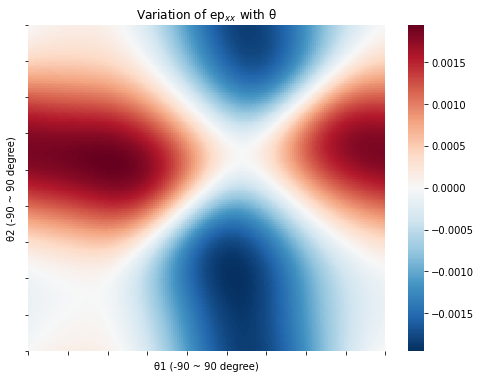

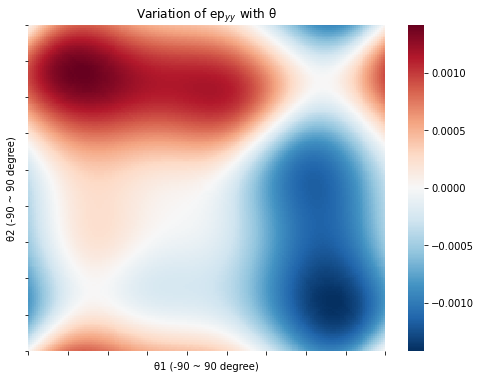

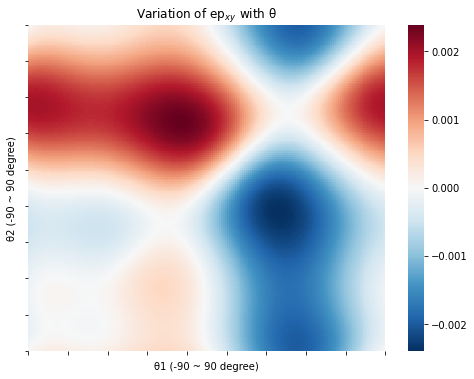

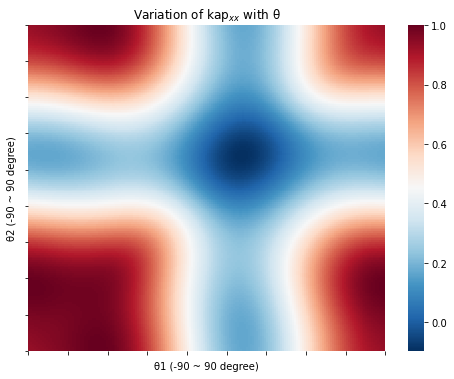

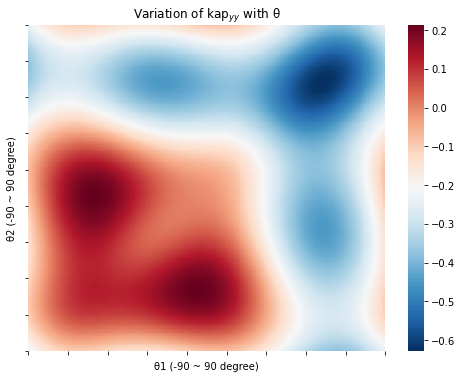

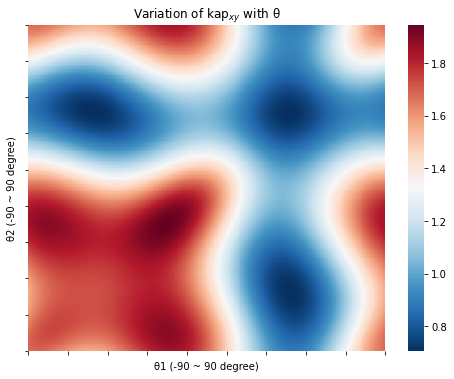

In [342]:
draw_deformations(load=Load_known_e, plate=0, label='ep$_x$$_x$')
draw_deformations(load=Load_known_e, plate=1, label='ep$_y$$_y$')
draw_deformations(load=Load_known_e, plate=2, label='ep$_x$$_y$')
draw_deformations(load=Load_known_e, plate=3, label='kap$_x$$_x$')
draw_deformations(load=Load_known_e, plate=4, label='kap$_y$$_y$')
draw_deformations(load=Load_known_e, plate=5, label='kap$_x$$_y$')